In [1]:
from backpack_predictor import prepare_data, target_encoding
from backpack_predictor.features import target, baseline_features, feature_list, cat_cols

%load_ext autoreload
%autoreload 2

from datetime import datetime
import time
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer, TargetEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

test_df = pd.read_csv(r'..//data//test.csv')
train_df = pd.read_csv(r'..//data//train.csv')
train_extra_df = pd.read_csv(r'..//data//training_extra.csv')
train_df = pd.concat([train_df, train_extra_df], ignore_index=True)

# cat_features = []
# train_df[cat_features] = train_df[cat_features].astype('category')
# test_df[cat_features] = test_df[cat_features].astype('category')

train_df = prepare_data(train_df, is_train=True)
test_df = prepare_data(test_df, is_train=False)

In [2]:
train_df

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,price,wc_decimal_count
0,3,0,1,7,1,0,2,0,11.611723,112.15875,15
1,3,3,0,10,1,1,1,4,27.078537,68.88056,14
2,4,0,0,2,1,0,1,2,16.643760,39.17320,15
3,2,1,0,8,1,0,1,4,12.937220,80.60793,15
4,0,3,1,1,1,1,1,4,17.749338,86.02312,15
...,...,...,...,...,...,...,...,...,...,...,...
3994313,2,3,-1,3,1,1,1,5,28.098120,104.74460,15
3994314,1,0,0,10,1,1,2,5,17.379531,122.39043,14
3994315,3,3,2,10,0,0,0,2,17.037708,148.18470,15
3994316,1,3,-1,2,0,0,0,1,28.783339,22.32269,14


In [3]:
# col1 = 'brand'
col1 = 'material'
col2 = 'is_waterproof'
stats = ['mean', 'skew', 'var', 'count']

agg_stats = train_df.groupby(col1)[col2].agg(stats)
agg_stats

,mean,skew,var,count
material,,,,
-1,0.482679,-0.208553,0.276631,110962
0,0.470462,-0.320208,0.296113,976186
1,0.468796,-0.316200,0.296348,942656
2,0.468634,-0.333528,0.298894,1060882
3,0.468095,-0.309644,0.295763,903632


In [ ]:
import itertools

best_pairs = ['material_is_waterproof', 'material_laptop_compartment', 'material_size', 'material_style', 'is_waterproof_color', 'style_color']

cols = ['brand', 'material', 'size', 'laptop_compartment', 'is_waterproof', 'style', 'color']
for col1, col2 in itertools.combinations(cols, 2):
    combined_col_name = f"{col1}_{col2}"

    if combined_col_name not in best_pairs:
        continue

    train_df[combined_col_name] = (
        train_df[col1].astype(str) + "_" + train_df[col2].astype(str)
    )#.astype('category')

    test_df[combined_col_name] = (
        test_df[col1].astype(str) + "_" + test_df[col2].astype(str)
    )#.astype('category')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 17 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   brand                        int32  
 1   material                     int32  
 2   size                         int32  
 3   compartments                 int32  
 4   laptop_compartment           int32  
 5   is_waterproof                int32  
 6   style                        int32  
 7   color                        int32  
 8   weight_capacity              float64
 9   price                        float64
 10  wc_decimal_count             int64  
 11  material_size                object 
 12  material_laptop_compartment  object 
 13  material_is_waterproof       object 
 14  material_style               object 
 15  is_waterproof_color          object 
 16  style_color                  object 
dtypes: float64(2), int32(8), int64(1), object(6)
memory usage: 396.2+ MB


In [ ]:
# %%time

lgb_params_1 = {'force_col_wise': True, 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'early_stopping_rounds': 916, 'cat_l2': 40.57932515907615, 'extra_trees': False, 'feature_fraction': 0.9028265875188044, 'learning_rate': 0.02133798565133846, 'max_bin': 7449, 'max_depth': 590, 'min_samples_leaf': 22, 'n_estimators': 14706, 'num_leaves': 141, 'lambda_l1': 0.004931837373939155, 'lambda_l2': 2.1647829905701264e-06}

stats = ['mean', 'skew', 'count', 'var']
FOLDS = 20

# Target sets use the target variable, and must be trained on the inner CV loop.
target_feature_cols = ['weight_capacity', 'compartments', 'wc_decimal_count', 'brand', 'color', 'laptop_compartment', 'is_waterproof', 'size', 'material', 'style'] + best_pairs
target_feature_sets = {
    f"{col1}": {
        "stats": stats
    }
    for col1 in target_feature_cols
}

all_new_cols = []
for col1, v in target_feature_sets.items():
    new_cols = [f"{col1}_{target}_{stat}" for stat in stats]
    target_feature_sets[col1]['new_cols'] = new_cols
    all_new_cols.extend(new_cols)

feature_sets = {
    'material': {
        'col2_list': ['is_waterproof', 'laptop_compartment', 'style', 'size'],
        'stats': stats,
    },
}
for col1, v in feature_sets.items():
    col2_list = v['col2_list']
    new_cols = [f"{col1}_{col2}_{stat}" for col2 in col2_list for stat in stats]
    feature_sets[col1]['new_cols'] = new_cols
    all_new_cols.extend(new_cols)

features = [
    'weight_capacity', 'compartments', 'wc_decimal_count',
    'laptop_compartment', 'is_waterproof', 'brand', 'color', 'size', 'material', 'style' 
] + all_new_cols

print(f"Using {len(features)} features.")


# Prepare arrays for out-of-fold and test predictions
oof = np.zeros(len(train_df), dtype=float)
pred = np.zeros(len(test_df), dtype=float)

rmse_list = []

kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
for i, (train_idx, valid_idx) in enumerate(kf.split(train_df), 1):
    train_fold = train_df.loc[train_idx].reset_index(drop=True)
    valid_fold = train_df.loc[valid_idx].reset_index(drop=True)

    # -----------------------------------------------------
    # Inner K-Fold (for partial target encoding)
    # -----------------------------------------------------
    kf_inner = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    for j, (inner_train_idx, inner_valid_idx) in enumerate(kf_inner.split(train_fold)):
        inner_train = train_fold.loc[inner_train_idx].copy()

        for col1, v in target_feature_sets.items():
            stats = v['stats']
            new_cols = v['new_cols']
            agg_stats = inner_train.groupby(col1)[target].agg(stats)
            for stat, new_col in zip(stats, new_cols):
                train_fold.loc[inner_valid_idx, new_col] = train_fold.loc[inner_valid_idx, col1].map(agg_stats[stat])

    # -----------------------------------------------------
    # Outer K-Fold Add Feature Sets
    # -----------------------------------------------------
    for col1, v in target_feature_sets.items():
        stats = v['stats']
        new_cols = v['new_cols']
        agg_stats = inner_train.groupby(col1)[target].agg(stats)
        for stat, new_col in zip(stats, new_cols):
            valid_fold.loc[:, new_col] = valid_fold.loc[:, col1].map(agg_stats[stat])
            test_df.loc[:, new_col] = test_df.loc[:, col1].map(agg_stats[stat])

    for col1, v in feature_sets.items():
        stats = v['stats']
        col2_list = v['col2_list']
        new_cols = v['new_cols']
        for i, col2 in enumerate(col2_list):
            agg_stats = inner_train.groupby(col1)[col2].agg(stats)
            for stat, new_col in zip(stats, new_cols[i*len(stats):(i+1)*len(stats)]):
                train_fold.loc[:, new_col] = train_fold.loc[:, col1].map(agg_stats[stat])
                valid_fold.loc[:, new_col] = valid_fold.loc[:, col1].map(agg_stats[stat])
                test_df.loc[:, new_col] = test_df.loc[:, col1].map(agg_stats[stat])

    # -----------------------------------------------------
    # Modeling
    # -----------------------------------------------------
    train_data = lgb.Dataset(train_fold[features], label=train_fold[target])
    valid_data = lgb.Dataset(valid_fold[features], label=valid_fold[target], reference=train_data)
    
    model = lgb.train(
        params=lgb_params_1,
        train_set=train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'valid'],
    )
    y_pred = model.predict(valid_fold[features], num_iteration=model.best_iteration)
    
    rmse = root_mean_squared_error(valid_fold[target], y_pred)
    rmse_list.append(rmse)
    print(f"[{i}] RMSE: {rmse:.2f},  AVG: {np.mean(rmse_list):.2f}")

    oof[valid_idx] = y_pred
    pred += model.predict(test_df[features], num_iteration=model.best_iteration)

print(f"Mean RMSE: {np.mean(rmse_list):.2f}")

[i] RMSE: 38.67
[i] RMSE: 38.78
[i] RMSE: 38.73
[i] RMSE: 38.39
[i] RMSE: 38.57
[i] RMSE: 38.73
[i] RMSE: 38.73
[i] RMSE: 38.68
[i] RMSE: 38.54
[i] RMSE: 38.70
[i] RMSE: 38.63
[i] RMSE: 38.58
[i] RMSE: 38.48
[i] RMSE: 38.56
[i] RMSE: 38.65
[i] RMSE: 38.85
[i] RMSE: 38.73
[i] RMSE: 38.55
[i] RMSE: 38.53
[i] RMSE: 38.64
[i] RMSE: 38.61
[i] RMSE: 38.52
[i] RMSE: 38.61
[i] RMSE: 38.55
[i] RMSE: 38.66
[i] RMSE: 38.62
[i] RMSE: 38.71
[i] RMSE: 38.55
[i] RMSE: 38.69
[i] RMSE: 38.73
[i] RMSE: 38.74
[i] RMSE: 38.64
[i] RMSE: 38.71
[i] RMSE: 38.62
[i] RMSE: 38.59
[i] RMSE: 38.59
[i] RMSE: 38.63
[i] RMSE: 38.47
[i] RMSE: 38.75
[i] RMSE: 38.51
[i] RMSE: 38.68
[i] RMSE: 38.77
[i] RMSE: 38.55
[i] RMSE: 38.60
[i] RMSE: 38.67
[i] RMSE: 38.62
[i] RMSE: 38.73
[i] RMSE: 38.64
[i] RMSE: 38.62
[i] RMSE: 38.60
[i] RMSE: 38.67
[i] RMSE: 38.81
[i] RMSE: 38.79
[i] RMSE: 38.72
[i] RMSE: 38.81
[i] RMSE: 38.53
[i] RMSE: 38.76
[i] RMSE: 38.76
[i] RMSE: 38.86
[i] RMSE: 38.70
[i] RMSE: 38.63
[i] RMSE: 38.71
[i] RMSE

Note: Change OOF_VERSION

In [27]:
OOF_VERSION = 1
oof_path = f"..//data//oof_v{OOF_VERSION}.csv"
pd.DataFrame(oof).to_csv(oof_path, header=False, index=False)
print("Saving to:", oof_path)

Saving to: ..//data//oof_v1.csv


In [28]:
submit_df = test_df[['id']].copy()
submit_df['Price'] = (pred / FOLDS)
submit_path = f'..//submissions//' + datetime.now().strftime("%Y-%m-%d_%H-%M") + ".csv"
submit_df.to_csv(submit_path, index=False)
print("Saved to:", submit_path)
submit_df.head(5)

Saved to: ..//submissions//2025-02-23_08-27.csv


,id,Price
0,300000,81.538082
1,300001,82.923897
2,300002,88.530664
3,300003,77.294651
4,300004,79.515144


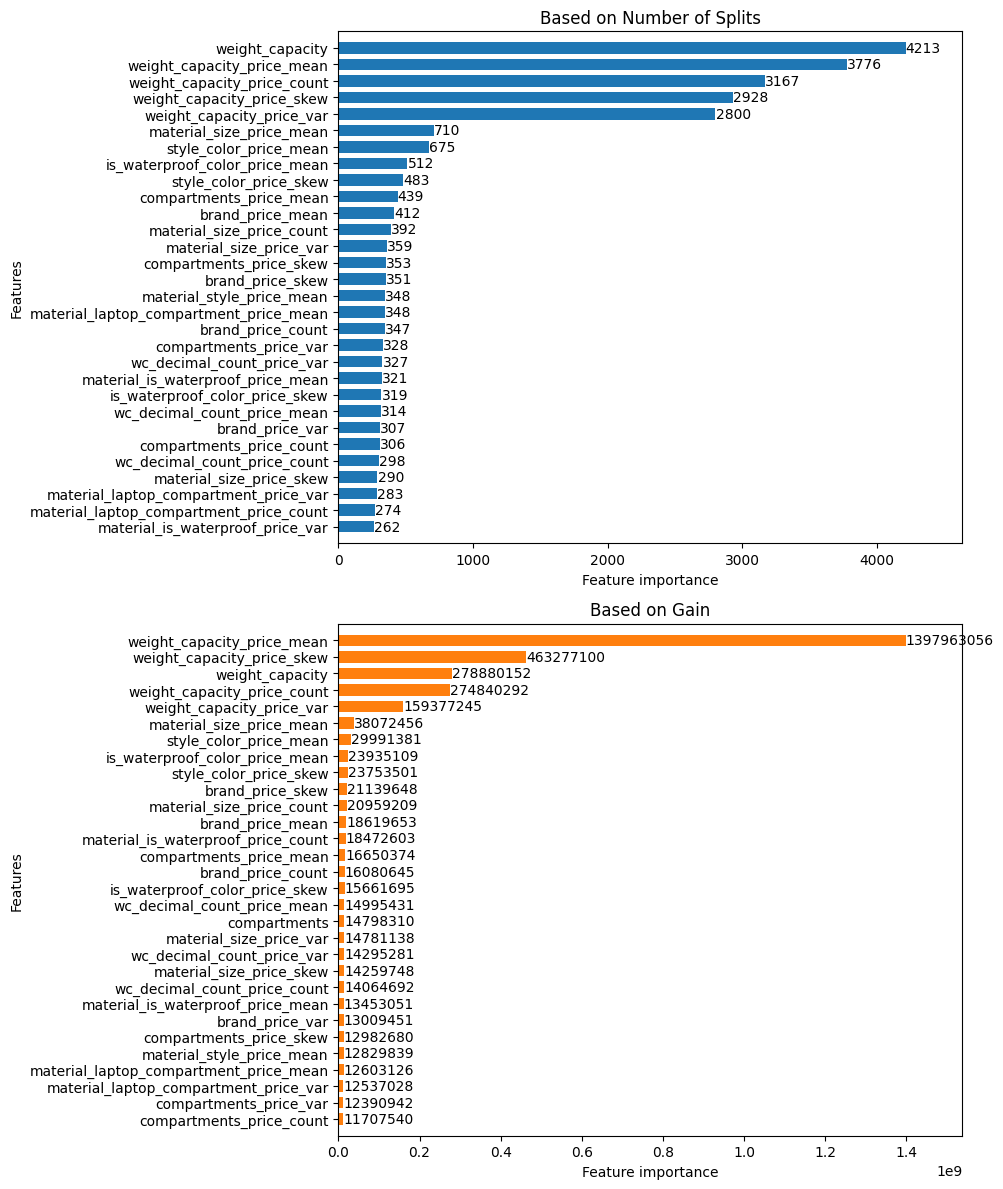

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

lgb.plot_importance(model, ax=axs[0], importance_type='split', max_num_features=30, 
                    height=0.7, grid=False, precision=0, color="tab:blue")
axs[0].set_title("Based on Number of Splits", fontsize=12)

lgb.plot_importance(model, ax=axs[1], importance_type='gain', max_num_features=30, 
                    height=0.7, grid=False, precision=0, color="tab:orange")
axs[1].set_title("Based on Gain", fontsize=12)

plt.tight_layout()
plt.show()